In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load Data and Check Data Types

In [7]:
train_data = pd.read_csv('./SERS_train.csv')
train_data.dtypes

edge_id                 int64
length                float64
way_type                int64
way_name               object
eta                   float64
timestamp               int64
coverage              float64
ata                   float64
latitude              float64
longitude             float64
is_tunnel             float64
user_group             object
way_segments_count      int64
dtype: object

In [3]:
def correct_data_types(df):
    df = df.astype({
        'way_type': 'category',
        'way_name': 'string',
        'user_group': 'category',
        'is_tunnel': 'category',
    })
    df.user_group = df.user_group.cat.codes
    df.is_tunnel = df.is_tunnel.cat.codes
    df.drop(['edge_id', 'way_name'],axis=1, inplace=True)
    return df

train_data = correct_data_types(train_data)
train_data.corr()[['ata','eta','length']]

,ata,eta,length
length,0.746048,0.879478,1.000000
way_type,0.032849,0.042678,0.066474
eta,0.801594,1.000000,0.879478
timestamp,-0.003898,-0.022502,-0.014597
coverage,0.101346,0.064468,0.056722
ata,1.000000,0.801594,0.746048
latitude,-0.019828,-0.022845,-0.069320
longitude,0.005098,-0.001512,0.008498
is_tunnel,0.001017,0.005021,0.005109
user_group,-0.004692,-0.003057,-0.002835


# Handle Missing values, Outliers, Invalid Data

In [4]:
train_data.isna().sum() 

length                  0
way_type                0
eta                     0
timestamp               0
coverage                0
ata                     0
latitude              163
longitude             163
is_tunnel               0
user_group              0
way_segments_count      0
dtype: int64

#### Because there is not many rows with NaN, we can drop them.

In [5]:
train_data = train_data.dropna()

#### For handling outliers, i used Z score.

In [6]:
def remove_z_score_outliers(df, column, th=3):
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    return df[np.abs(z_scores) <= th]

for col in train_data.columns:
    if train_data[col].dtype not in ['int64', 'float64']:
        continue
    train_data = remove_z_score_outliers(train_data,col)

# Feature Engineering

#### We can change the timestamp to 24 hours of a day.
#### By getting the longitude and latitude of the large cities in Iran from google. We also can use longitude and latitude features to reach the way's city.

In [7]:
def make_hour_column(df):
    
    def get_hour(unixtime):
        seconds = unixtime % 86400
        hour = math.floor(seconds / 3600)
        return hour

    df['hour'] = df['timestamp'].apply(get_hour)
    df = df.astype({'hour':'category',})
    df.hour = df.hour.cat.codes
    return df

train_data = make_hour_column(train_data)

In [8]:
provinces = [
    {"Tehran": [35.6892, 51.3890]},
    {"Mashhad": [36.2605, 59.6168]},
    {"Isfahan": [32.6546, 51.6680]},
    {"Karaj": [35.8400, 50.9391]},
    {"Tabriz": [38.0700, 46.3010]},
    {"Urmia": [37.5486, 45.0726]},
    {"Ardabil": [38.2498, 48.2933]},
    {"Bushehr": [28.9220, 50.8330]},
    {"Shahrekord": [31.9614, 50.8456]},
    {"Shiraz": [29.5918, 52.5836]},
    {"Rasht": [37.2808, 49.5832]},
    {"Gorgan": [36.8434, 54.4460]},
    {"Hamedan": [34.7987, 48.5146]},
    {"Bandar Abbas": [27.1832, 56.2666]},
    {"Ilam": [33.6370, 46.4227]},
    {"Kerman": [30.2832, 57.0788]},
    {"Kermanshah": [34.3277, 47.0778]},
    {"Ahvaz": [31.3273, 48.6946]},
    {"Yasuj": [30.6687, 51.5870]},
    {"Sanandaj": [35.3219, 46.9862]},
    {"Khorramabad": [33.5818, 48.3988]},
    {"Arak": [34.0800, 49.6941]},
    {"Sari": [36.2262, 52.5319]},
    {"Qazvin": [36.2688, 50.0041]},
    {"Qom": [34.6401, 50.8764]},
    {"Semnan": [35.5779, 53.3921]},
    {"Zahedan": [29.4963, 60.8629]},
    {"Birjand": [32.8663, 59.2214]},
    {"Yazd": [31.8974, 54.3569]},
    {"Zanjan": [36.6736, 48.4787]}
]
combined_dict = {k: v for d in provinces for k, v in d.items()}
provinces = {tuple((math.floor(v[0]),math.floor(v[1]))): k for k, v in combined_dict.items()}

In [9]:
def make_location_column(df):
    df['new_latitude'] = list(map(math.floor,df['latitude']))
    df['new_longitude'] = list(map(math.floor,df['longitude']))
    df['location'] = list(zip(df['new_latitude'],df['new_longitude']))
    return df

def make_city_column(df):
    df['city'] = [provinces[l] if l in provinces.keys() else 'NLC' for l in df['location']]
    return df

train_data = make_location_column(train_data)
train_data = make_city_column(train_data)

train_data = train_data.astype({'city': 'category',})

In [11]:
train_data.city = train_data.city.cat.codes
train_data['ata'] = train_data['ata'] / train_data['coverage']
train_data.drop(['timestamp', 'location', 'coverage', 'new_latitude', 'new_longitude'], axis=1, inplace=True)

# Finding Correlation

In [12]:
train_data.head()

,length,way_type,eta,ata,latitude,longitude,is_tunnel,user_group,way_segments_count,hour,city
0,36.713,7,13.007,6.704363,35.768834,51.469487,0,1,1,6,24
1,68.373,7,9.116,10.010962,35.800156,51.474850,0,0,1,10,24
2,76.896,7,6.291,7.222437,32.645556,51.659348,0,0,3,17,8
3,76.896,7,6.291,7.359428,32.645556,51.659348,0,0,1,3,8
4,869.709,9,38.182,32.991840,32.927357,51.517204,0,0,2,21,8


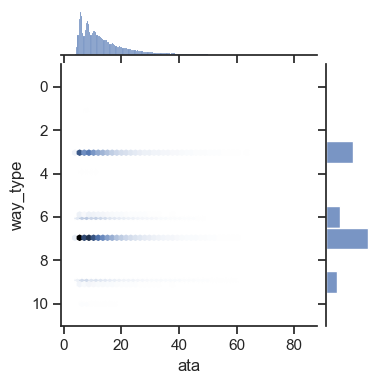

In [13]:
sns.set_theme(style="ticks")
sns.jointplot(
    data=train_data,
    x='ata',
    y='way_type',
    kind='hex', height=4
)

#### Most of the data has a way type of 3 or 7 and way type 7 can result in a greater ata than the others.

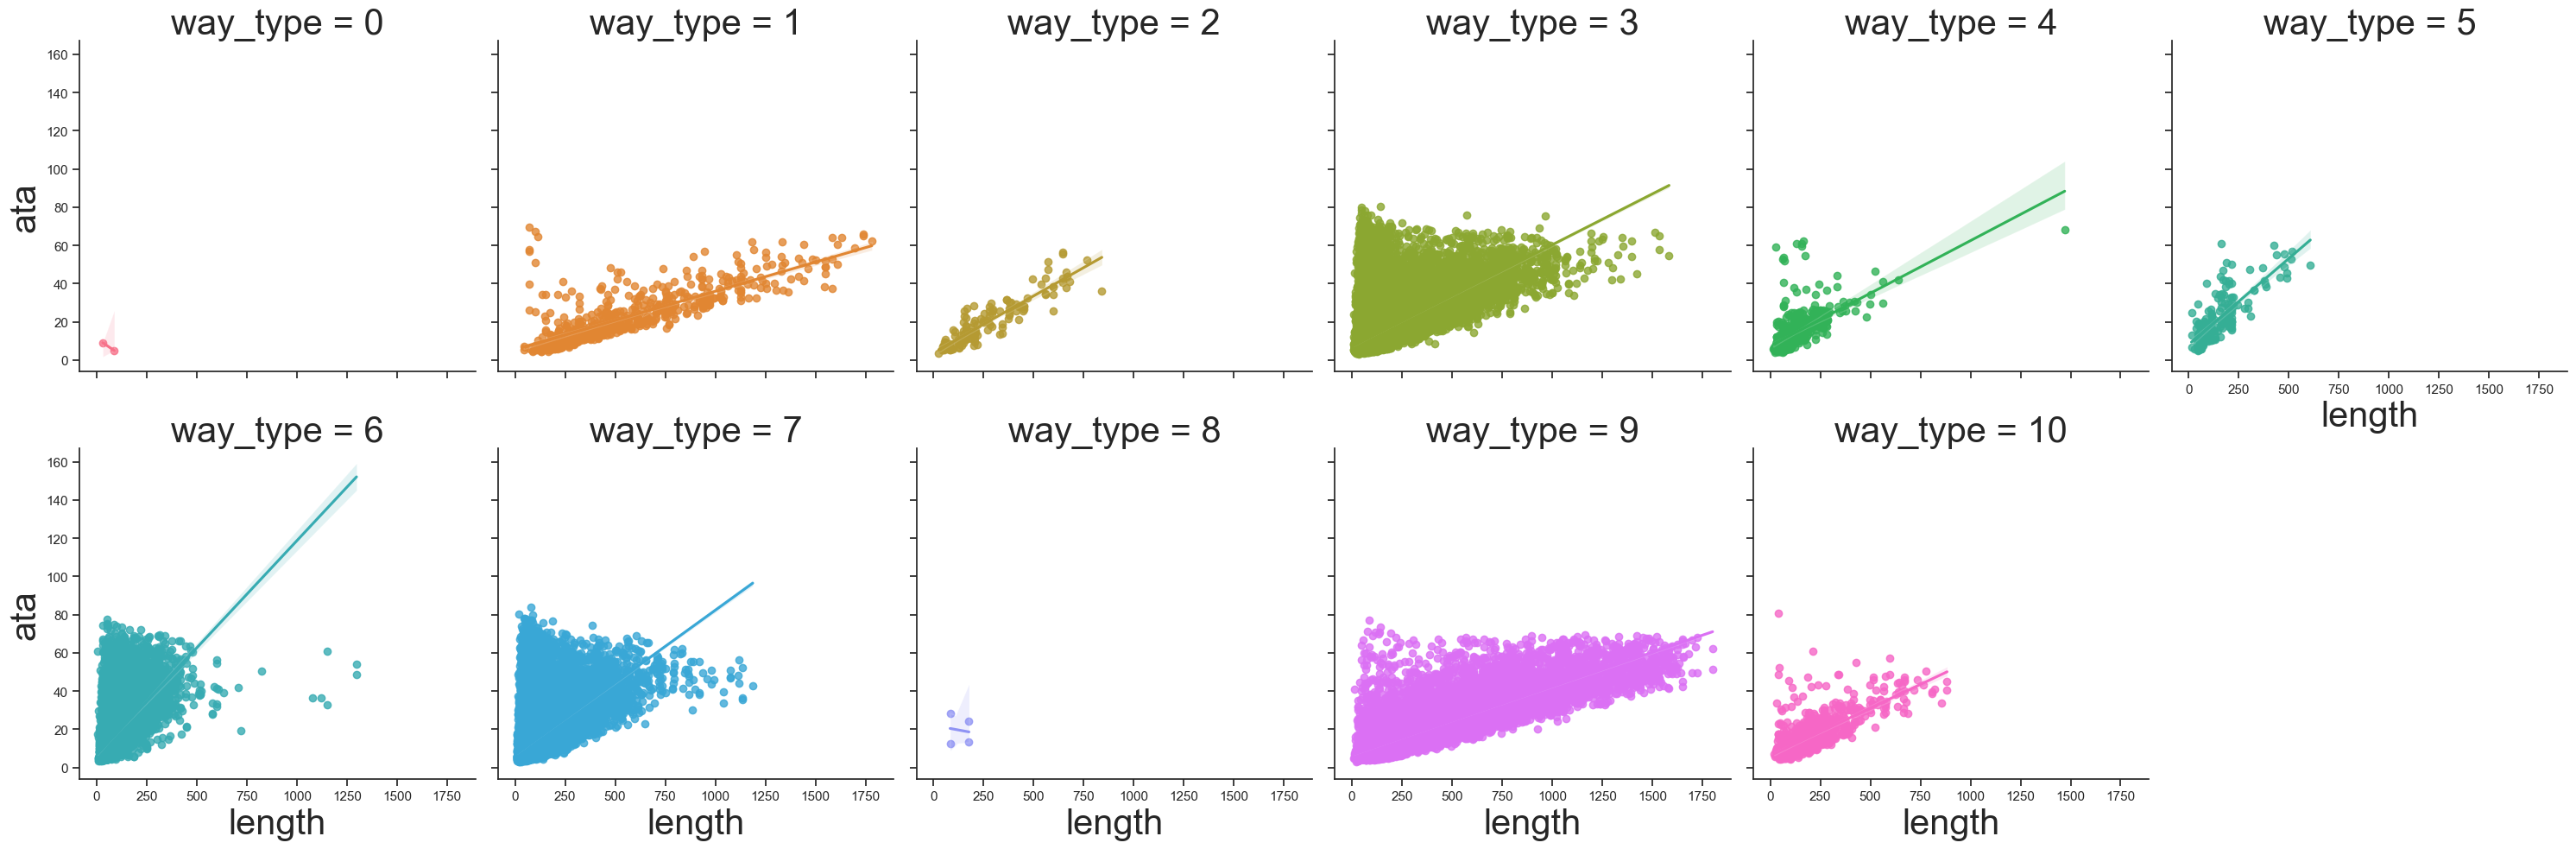

In [14]:
sns.set_context("notebook", rc={"axes.labelsize": 30})
sns.lmplot(
    data=train_data,
    x='length',
    y='ata',
    col='way_type',hue='way_type',
    col_wrap=6
)

#### We can see a correlation between length and way type in most of the way types.
#### So if the way type is 1, 2, 5 it is easy to predict ata just by using length with a linear model. But there is a problem in predicting ata for 3, 6, 7, 9 way types and we must use other features.
#### As you see, we have few samples for way types 1 and 8, so the model can't learn them well.

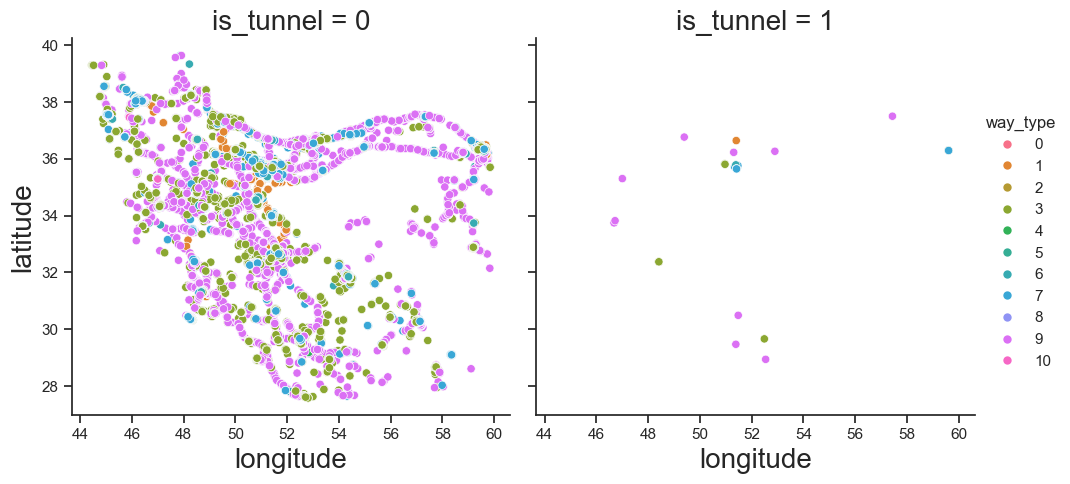

In [15]:
sns.set_context("notebook", rc={"axes.labelsize": 20})
sns.relplot(
    data=train_data,
    y='latitude',
    x='longitude',
    hue='way_type',col='is_tunnel'
)

#### As mentioned in above cell the problem is 3 and 9 way types. Here we can see there are not in city. So city feature would not help us in this problem.
#### The most of the tunnel datas are way type 9.

# Training Data

#### About training the data, predicting ATA is a regression problem. So i train the data in 3 different models (Linear Regression, Random Forest, Gradient Boosting)
#### The test data doesn't have ata feature. So i split the train data for training and evaluation. Then we can choose predict the test data with least error model.

In [16]:
X = train_data.drop(['ata'], axis=1)
y = train_data['ata']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(random_state=42)
gradient_boosting_model = GradientBoostingRegressor(random_state=42)

In [ ]:
for _ in tqdm(range(100), desc='Linear Regression Training'):
    linear_model.fit(X_train, y_train)

for _ in tqdm(range(1), desc='Random Forest Training'):
    random_forest_model.fit(X_train, y_train)

for _ in tqdm(range(10), desc='Gradient Boosting Training'):
    gradient_boosting_model.fit(X_train, y_train)

Random Forest Training:   0%|                                                                    | 0/1 [00:00<?, ?it/s]

# Validation

In [19]:
linear_pred = linear_model.predict(X_test)
rf_pred = random_forest_model.predict(X_test)
gb_pred = gradient_boosting_model.predict(X_test)

In [20]:
def get_MAPE(ETA,ATA):
    return np.mean(np.abs((ETA - ATA) / ATA)) * 100

eta_test = X_test['eta'].values 

real_mape = get_MAPE(eta_test, y_test)
linear_mape = get_MAPE(eta_test, linear_pred)
rf_mape = get_MAPE(eta_test, rf_pred)
gb_mape = get_MAPE(eta_test, gb_pred)

linear_mae = mean_absolute_error(y_test, linear_pred)
linear_mse = mean_squared_error(y_test, linear_pred)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)

gb_mae = mean_absolute_error(y_test, gb_pred)
gb_mse = mean_squared_error(y_test, gb_pred)

pd.DataFrame({
    'Model':['Real', 'Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'MAPE':[real_mape, linear_mape, rf_mape, gb_mape],
    'Mean Absolute Error':[0,linear_mae, rf_mae, gb_mae],
    'Mean Squared Error':[0,linear_mse, rf_mse, gb_mse],
})

,Model,MAPE,Mean Absolute Error,Mean Squared Error
0,Real,30.454412,0.000000,0.000000
1,Linear Regression,14.105565,4.143339,46.321669
2,Random Forest,17.866431,4.178981,46.653785
3,Gradient Boosting,15.190070,3.984973,44.510955


#### We found out trained data's MAPE is close to half of it in the data before training.
#### As we see, the Linear Regression and Gradient Boosting model is a good model for training this data by considering which error is more important? The error of (ETA - ATA) or predicting ATA.
#### The goal is to predict ATA as close as it could be to ETA. Therefore we choose Linear regression model.

# MAPE for TEST Data

In [21]:
import warnings
warnings.filterwarnings('ignore')
# there is a warning in predicting test data because of the feature names but the model gets it right.

# cleaning test data and make the new features
test_data = pd.read_csv('./SERS_test.csv')
test_data = correct_data_types(test_data)
test_data = make_hour_column(test_data)
test_data = make_location_column(test_data)
test_data = make_city_column(test_data)

test_data = test_data.astype({'city': 'category',})
test_data.city = test_data.city.cat.codes
test_data.drop(['timestamp', 'location', 'coverage', 'new_latitude', 'new_longitude', 'location'], axis=1, inplace=True)
eta_test_data = test_data['eta'].values
test_data_columns = test_data.columns
test_data = test_data.to_numpy()

linear_pred_test_data = linear_model.predict(test_data)
test_data_mape = get_MAPE(eta_test_data, linear_pred_test_data)
print(f"The Test Data's MAPE: {test_data_mape}")

The Test Data's MAPE: 14.204053771029782


#### We can see that test data's MAPE is so close to the MAPE of the train data part we use to validation, so we can found out the model works well. 

In [22]:
pd.DataFrame({
    'Features':test_data_columns,
    'Weights':linear_model.coef_
})

,Features,Weights
0,length,0.013622
1,way_type,-0.057111
2,eta,0.660581
3,latitude,0.096848
4,longitude,-0.024003
5,is_tunnel,0.107247
6,user_group,0.023135
7,way_segments_count,0.009042
8,hour,-0.000651
9,city,0.006007


#### As you see the city and hour features didn't help the model so much.
#### The important features that was useful for the model are ETA, Length, latitude and being a tunnel or not.